In [1]:
# Load libraries
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy import stats

https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

In [2]:
df = pd.read_csv('Files/working/ppr_analysis.csv', dtype={'draft_id':'object', 'user_id':'object'})

In [3]:
df['draft_val'] = (df['r1_pick'] - df['r1_adp']) + (df['r2_pick'] - df['r2_adp']) #+(df['r3_pick'] - df['r3_adp']) + (df['r4_pick'] - df['r4_adp'])

In [4]:
df['r1_val'] = df['r1_pick'] - df['r1_adp']
df['r2_val'] = df['r2_pick'] - df['r2_adp']
df['r3_val'] = df['r3_pick'] - df['r3_adp']
df['r4_val'] = df['r4_pick'] - df['r4_adp']

In [5]:
df['dvz'] = np.abs(stats.zscore(df['draft_val'], nan_policy='omit'))
df = df[df['dvz'] < 3]

df['rvz'] = np.abs(stats.zscore(df['r1_val'], nan_policy='omit'))
df = df[df['rvz'] < 3]

In [6]:
df['strategy'] = df['r1_pos'] + df['r2_pos']
strat = df.groupby('strategy')['user_id'].size().reset_index().sort_values(by='user_id', ascending=False).reset_index(drop=True)
strat['strategy_id'] = strat.index + 1
strat = strat[strat['strategy_id'] <=10]

In [8]:
df = df.merge(strat[['strategy','strategy_id']], how='left')
ls = df.groupby('draft_id')['slot'].max().reset_index()
ls.columns = ['draft_id','league_size']
df = df.merge(ls, on='draft_id', how='left')
df = df[df['league_size'] == 10]
len(df.draft_id.drop_duplicates())

1275

In [19]:
dataset = df[['slot','strategy_id','draft_val','r1_val','points_standing']]
dataset['points_standing'] = dataset['points_standing'].astype(str)
dataset = dataset.dropna()

/var/folders/w2/0q5xhrf578d2c6cdn9g187jm0000gn/T/ipykernel_64784/2159532563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['points_standing'] = dataset['points_standing'].astype(str)


In [39]:
dataset = dataset[dataset['points_standing'].astype(float) % 1 == 0]
dataset = dataset[dataset['points_standing'].astype(float) <= 10]

In [40]:
print(dataset.groupby('points_standing').size())

points_standing
1.0     1209
10.0    1121
2.0     1208
3.0     1180
4.0     1178
5.0     1178
6.0     1159
7.0     1158
8.0     1150
9.0     1147
dtype: int64


In [41]:
dataset.describe()

,slot,strategy_id,draft_val,r1_val
count,11688.000000,11688.000000,11688.000000,11688.000000
mean,5.458761,2.653833,-12.459788,-3.087697
std,2.878833,2.099750,13.071887,4.431071
min,1.000000,1.000000,-125.000000,-33.000000
25%,3.000000,1.000000,-16.000000,-5.000000
50%,5.000000,2.000000,-10.000000,-2.000000
75%,8.000000,4.000000,-5.000000,-0.750000
max,10.000000,10.000000,17.000000,9.000000


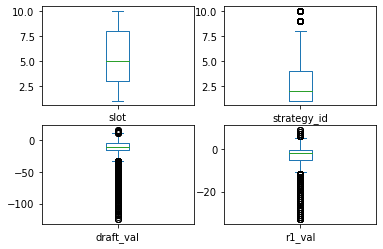

In [42]:
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

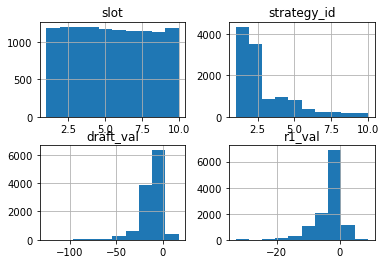

In [43]:
dataset.hist()
pyplot.show()

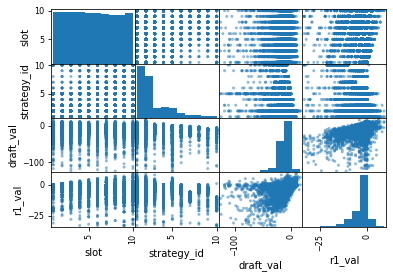

In [44]:
scatter_matrix(dataset)
pyplot.show()

## 5.1

In [45]:
array = dataset.values

In [46]:
X = array[:,0:4]
y = array[:,4]

In [47]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [48]:
...
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.121604 (0.008075)
LDA: 0.120107 (0.007990)
KNN: 0.122460 (0.006649)
CART: 0.124599 (0.010013)
NB: 0.122888 (0.011252)
SVM: 0.126738 (0.011004)


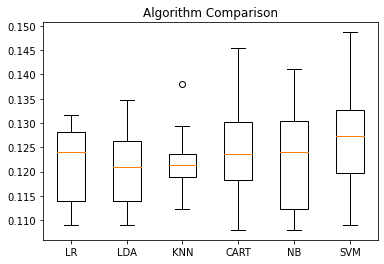

In [49]:
...
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [50]:
# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [52]:
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.1360136869118905
[[73  9 31 21 17 20 13 15 19 15]
 [17 34 14  7 17 40 21 32 30 26]
 [54 15 46 19 12 25 20 16 18 16]
 [50 18 24 12 20 32 23 17 23 15]
 [43 18 20 19 14 25 27 25 19 26]
 [37 27 34 12 16 38 18 31 19 21]
 [34 30 19 15 19 32 16 21 27 20]
 [23 20 17 17 14 27 24 25 30 16]
 [26 27 14 12 19 32 25 18 34 21]
 [21 31 20  8 26 27 19 24 27 26]]
              precision    recall  f1-score   support

         1.0       0.19      0.31      0.24       233
        10.0       0.15      0.14      0.15       238
         2.0       0.19      0.19      0.19       241
         3.0       0.08      0.05      0.06       234
         4.0       0.08      0.06      0.07       236
         5.0       0.13      0.15      0.14       253
         6.0       0.08      0.07      0.07       233
         7.0       0.11      0.12      0.11       213
         8.0       0.14      0.15      0.14       228
         9.0       0.13      0.11      0.12       229

    accuracy                           0.14      2338
